In [26]:
import time
import os
import scipy.io
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from gan_pde import*
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
rc('text', usetex=False)

%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 

# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.Session(config=config)

seed  = 334
tf.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [27]:
path_lib = os.path.dirname(os.getcwd())
path_resources = os.path.join(path_lib, 'resources')
path_data = os.path.join(path_resources, 'data')
path_models = os.path.join(path_resources, 'models')
print(path_data)

filename = 'burgers_shock.mat'
path_file = os.path.join(path_data, filename)
data = scipy.io.loadmat(path_file)

D:\Tenokonda Ltd Dropbox\Cedric Fraces\Projects\PhysicsInformed\lib\resources\data


In [28]:
# CONFIG

# n_u = 200
n_boundary_t_0 = 50
# n_boundary_t_0 = 100 #for the uncertainty in paper 100 points at t=0
n_boundary_x_minus_1 = 50
n_boundary_x_1 = 50

# noise = 0.2

latent_var_nb = 1

gen_layer_lst = [50, 50, 50, 50, 1]
pos_layer_lst = [50, 50, 50, 50, 1]
dis_layer_lst = [50, 50, 50, 1]

gen_activation_lst = [tf.nn.tanh for i in range(len(gen_layer_lst)-1)]
pos_activation_lst = [tf.nn.tanh for i in range(len(pos_layer_lst)-1)]
dis_activation_lst = [tf.nn.tanh for i in range(len(dis_layer_lst)-1)]
gen_activation_lst.append(None)
pos_activation_lst.append(None)
dis_activation_lst.append(None)

w_pde_loss = 1.0
w_posterior_loss = 1.5

learning_rate = 0.0001
batch_size = 150
batch_size_collocation = 2000
dis_steps_nb = 1
gen_steps_nb = 5
iter_nb = 20000

In [29]:
t_data = data['t'].flatten()[:, None]
x_data = data['x'].flatten()[:, None]
u_actual = np.real(data['usol']).T
x_mesh, t_mesh = np.meshgrid(x_data, t_data)

scale=0.1
epsilon = np.random.normal(loc=0.0, scale=scale, size=x_data.shape[0])
delta = epsilon / np.exp(3 * np.abs(x_data[:,0]))
u_actual[0,:] = -np.sin(np.pi * (x_data[:,0] + 2.0 * delta)) + delta

data_dict = dict(x=x_mesh.flatten(), t=t_mesh.flatten(), u=u_actual.flatten())
df_data = pd.DataFrame(data_dict)

C:\Users\cedric\Anaconda3\envs\py36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


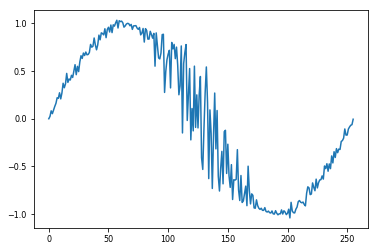

In [30]:
plt.plot(u_actual[0,:])

C:\Users\cedric\Anaconda3\envs\py36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


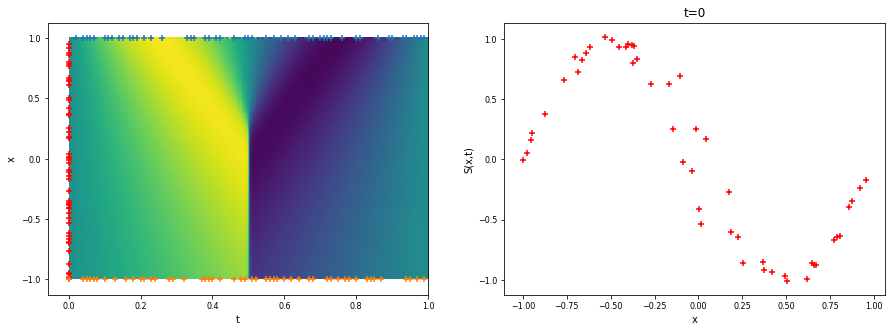

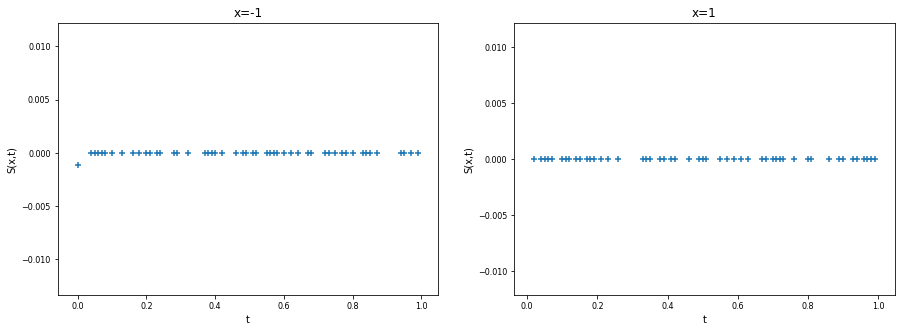

In [45]:
np.random.seed(seed)
random.seed(seed)

# idx_train = pd.Index(np.random.choice(len(df_data), n_u, replace=False))

idx_boundary_t_0 = pd.Index(np.random.choice(df_data[df_data.t == 0.0].index, n_boundary_t_0, replace=False))
idx_boundary_x_1 = pd.Index(np.random.choice(df_data[df_data.x == 1.0].index, n_boundary_x_1, replace=False))
idx_boundary_x_minus_1 = pd.Index(np.random.choice(df_data[df_data.x == -1.0].index, n_boundary_x_minus_1, replace=False))
idx_train = idx_boundary_t_0.append((idx_boundary_x_minus_1, idx_boundary_x_1))

# scale=0.1
# epsilon = np.random.normal(loc=0.0, scale=scale, size=df_data.loc[idx_boundary_t_0, 'x'].shape[0])
# delta = epsilon / np.exp(3 * np.abs(df_data.loc[idx_boundary_t_0, 'x']))
# df_data.loc[idx_boundary_t_0, 'u'] = -np.sin(np.pi * (df_data.loc[idx_boundary_t_0, 'x'] + 2.0 * delta)) + delta

idx_test = df_data.index.difference(idx_train)

u_train = df_data.u[idx_train].values[:,None]

#adding noise
# u_train = u_train + noise * np.std(u_train) * np.random.randn(u_train.shape[0])
x_train = df_data.x[idx_train].values[:,None]
t_train = df_data.t[idx_train].values[:,None]

u_test = df_data.u[idx_test].values[:,None]
x_test = df_data.x[idx_test].values[:,None]
t_test = df_data.t[idx_test].values[:,None]

# Plot training set
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].imshow(df_data.u.values.reshape((100,256)),extent=[0,1,-1,1],aspect='auto')
axs[0].scatter(df_data.loc[idx_boundary_t_0, 't'], df_data.loc[idx_boundary_t_0, 'x'],c='r',marker="+")
axs[0].scatter(df_data.loc[idx_boundary_x_1, 't'], df_data.loc[idx_boundary_x_1, 'x'],marker="+")
axs[0].scatter(df_data.loc[idx_boundary_x_minus_1, 't'], df_data.loc[idx_boundary_x_minus_1, 'x'],marker="+")
axs[0].set(xlabel='t', ylabel='x')
# plt.tight_layout()
axs[1].scatter(df_data.loc[idx_boundary_t_0, 'x'], df_data.loc[idx_boundary_t_0, 'u'],c='r', marker='+')
axs[1].set(xlabel='x', ylabel='S(x,t)')
axs[1].title.set_text('t=0')
#
fig2, axs2 = plt.subplots(1,2,figsize=(15,5))
axs2[0].scatter(df_data.loc[idx_boundary_x_minus_1, 't'], df_data.loc[idx_boundary_x_minus_1, 'u'], marker='+')
axs2[0].set(xlabel='t', ylabel='S(x,t)')
axs2[0].title.set_text('x=-1')
#
axs2[1].scatter(df_data.loc[idx_boundary_x_1, 't'], df_data.loc[idx_boundary_x_1, 'u'], marker='+')
axs2[1].set(xlabel='t', ylabel='S(x,t)')
axs2[1].title.set_text('x=1')

Iter: 0,  discriminator: 1.4003,  generator: 0.4246,  entropy: 0.0441,  posterior: 0.3298,  pde: 0.0507


C:\Users\cedric\Anaconda3\envs\py36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


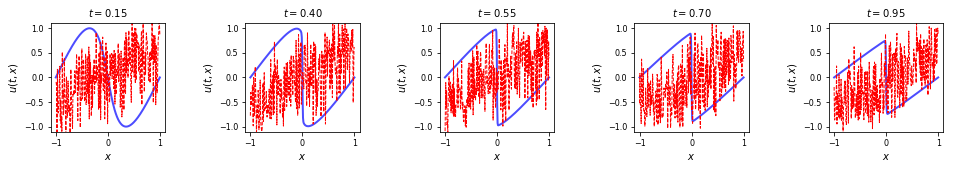

Iter: 100,  discriminator: 1.3088,  generator: 0.2149,  entropy: 0.2028,  posterior: 0.0017,  pde: 0.0104
Iter: 200,  discriminator: 1.5191,  generator: -0.2354,  entropy: -0.2550,  posterior: 0.0011,  pde: 0.0186
Iter: 300,  discriminator: 1.7241,  generator: -0.6555,  entropy: -0.6902,  posterior: 0.0012,  pde: 0.0335
Iter: 400,  discriminator: 1.6532,  generator: -0.5048,  entropy: -0.5180,  posterior: 0.0005,  pde: 0.0128
Iter: 500,  discriminator: 1.6212,  generator: -0.4235,  entropy: -0.4408,  posterior: 0.0003,  pde: 0.0170


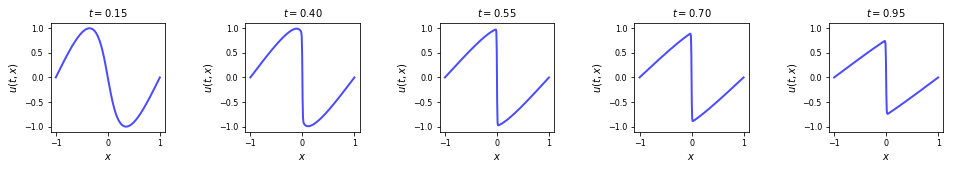

Iter: 600,  discriminator: 1.4291,  generator: -0.0779,  entropy: -0.0796,  posterior: 0.0001,  pde: 0.0016
Iter: 700,  discriminator: 1.3755,  generator: 0.0388,  entropy: 0.0379,  posterior: 0.0001,  pde: 0.0008
Iter: 800,  discriminator: 1.3766,  generator: 0.0229,  entropy: 0.0225,  posterior: 0.0001,  pde: 0.0003
Iter: 900,  discriminator: 1.3801,  generator: 0.0318,  entropy: 0.0312,  posterior: 0.0000,  pde: 0.0005
Iter: 1000,  discriminator: 1.3877,  generator: -0.0017,  entropy: -0.0020,  posterior: 0.0000,  pde: 0.0004


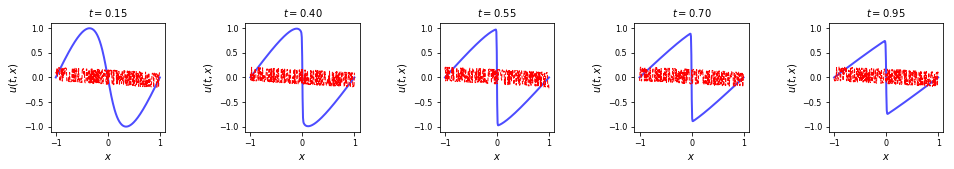

Iter: 1100,  discriminator: 1.3941,  generator: -0.0022,  entropy: -0.0023,  posterior: 0.0000,  pde: 0.0001
Iter: 1200,  discriminator: 1.3853,  generator: 0.0167,  entropy: 0.0163,  posterior: 0.0000,  pde: 0.0003
Iter: 1300,  discriminator: 1.3937,  generator: -0.0068,  entropy: -0.0072,  posterior: 0.0000,  pde: 0.0004
Iter: 1400,  discriminator: 1.3883,  generator: -0.0011,  entropy: -0.0013,  posterior: 0.0000,  pde: 0.0002
Iter: 1500,  discriminator: 1.3850,  generator: 0.0056,  entropy: 0.0054,  posterior: 0.0000,  pde: 0.0002


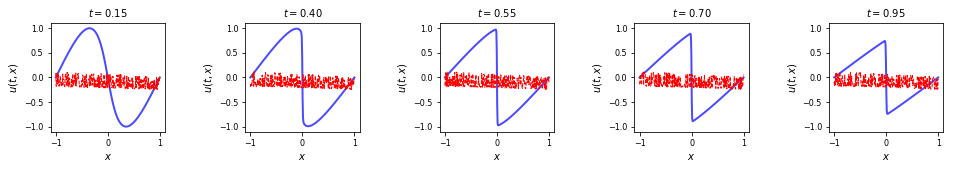

Iter: 1600,  discriminator: 1.3832,  generator: 0.0094,  entropy: 0.0091,  posterior: 0.0000,  pde: 0.0002
Iter: 1700,  discriminator: 1.3885,  generator: -0.0043,  entropy: -0.0050,  posterior: 0.0000,  pde: 0.0007
Iter: 1800,  discriminator: 1.3876,  generator: 0.0044,  entropy: 0.0042,  posterior: 0.0000,  pde: 0.0002
Iter: 1900,  discriminator: 1.3844,  generator: 0.0057,  entropy: 0.0056,  posterior: 0.0000,  pde: 0.0001
Iter: 2000,  discriminator: 1.3839,  generator: 0.0126,  entropy: 0.0123,  posterior: 0.0000,  pde: 0.0003


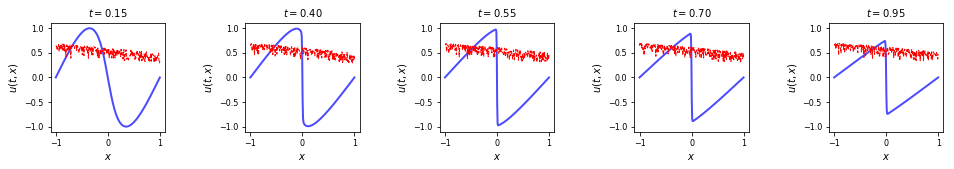

Iter: 2100,  discriminator: 1.3977,  generator: -0.0130,  entropy: -0.0133,  posterior: 0.0000,  pde: 0.0003
Iter: 2200,  discriminator: 1.3982,  generator: -0.0203,  entropy: -0.0210,  posterior: 0.0000,  pde: 0.0008
Iter: 2300,  discriminator: 1.3895,  generator: 0.0012,  entropy: 0.0009,  posterior: 0.0000,  pde: 0.0003
Iter: 2400,  discriminator: 1.3852,  generator: 0.0052,  entropy: 0.0051,  posterior: 0.0000,  pde: 0.0001
Iter: 2500,  discriminator: 1.3833,  generator: 0.0076,  entropy: 0.0075,  posterior: 0.0000,  pde: 0.0001


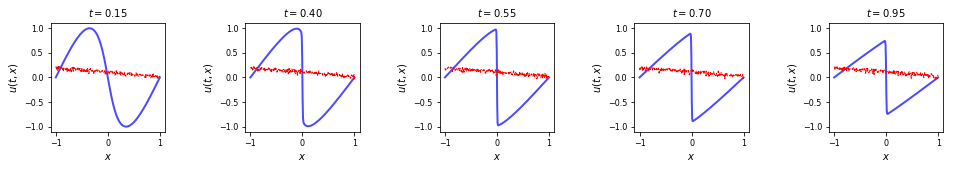

Iter: 2600,  discriminator: 1.3765,  generator: 0.0141,  entropy: 0.0140,  posterior: 0.0000,  pde: 0.0001
Iter: 2700,  discriminator: 1.4216,  generator: -0.0772,  entropy: -0.0776,  posterior: 0.0000,  pde: 0.0004
Iter: 2800,  discriminator: 1.4146,  generator: -0.0377,  entropy: -0.0382,  posterior: 0.0000,  pde: 0.0005
Iter: 2900,  discriminator: 1.4093,  generator: -0.0382,  entropy: -0.0387,  posterior: 0.0000,  pde: 0.0005
Iter: 3000,  discriminator: 1.3853,  generator: 0.0018,  entropy: 0.0017,  posterior: 0.0000,  pde: 0.0001


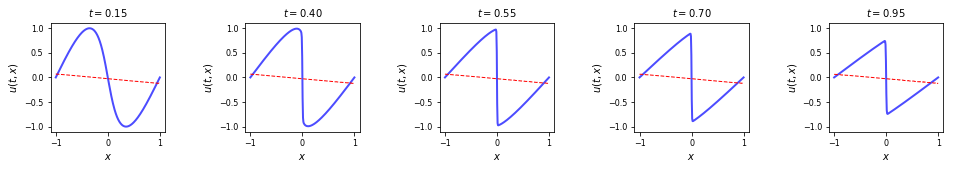

Iter: 3100,  discriminator: 1.3887,  generator: 0.0087,  entropy: 0.0086,  posterior: 0.0000,  pde: 0.0001
Iter: 3200,  discriminator: 1.4014,  generator: -0.0173,  entropy: -0.0173,  posterior: 0.0000,  pde: 0.0001
Iter: 3300,  discriminator: 1.3972,  generator: -0.0080,  entropy: -0.0085,  posterior: 0.0000,  pde: 0.0006
Iter: 3400,  discriminator: 1.3831,  generator: 0.0198,  entropy: 0.0195,  posterior: 0.0000,  pde: 0.0003
Iter: 3500,  discriminator: 1.3832,  generator: 0.0178,  entropy: 0.0173,  posterior: 0.0000,  pde: 0.0005


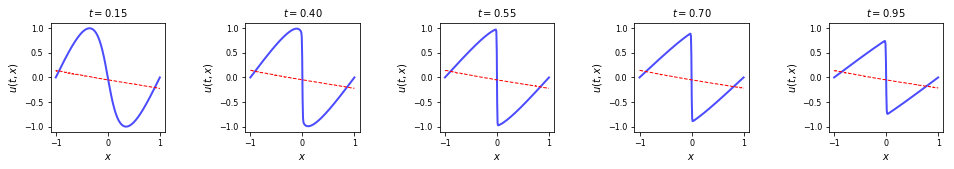

Iter: 3600,  discriminator: 1.4014,  generator: -0.0273,  entropy: -0.0282,  posterior: 0.0000,  pde: 0.0009
Iter: 3700,  discriminator: 1.3908,  generator: -0.0130,  entropy: -0.0134,  posterior: 0.0000,  pde: 0.0004
Iter: 3800,  discriminator: 1.3806,  generator: 0.0277,  entropy: 0.0269,  posterior: 0.0000,  pde: 0.0008
Iter: 3900,  discriminator: 1.3789,  generator: -0.0042,  entropy: -0.0054,  posterior: 0.0000,  pde: 0.0011
Iter: 4000,  discriminator: 1.3799,  generator: 0.0295,  entropy: 0.0291,  posterior: 0.0000,  pde: 0.0004


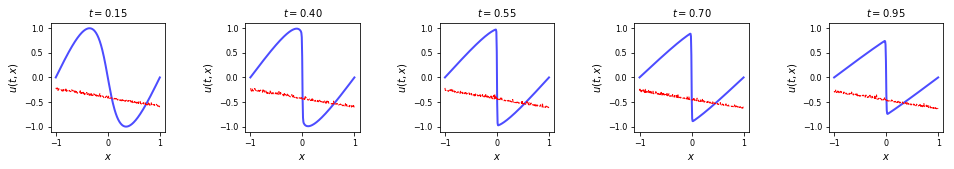

Iter: 4100,  discriminator: 1.3945,  generator: -0.0173,  entropy: -0.0178,  posterior: 0.0000,  pde: 0.0005
Iter: 4200,  discriminator: 1.3860,  generator: -0.0057,  entropy: -0.0065,  posterior: 0.0000,  pde: 0.0007
Iter: 4300,  discriminator: 1.3741,  generator: 0.0343,  entropy: 0.0323,  posterior: 0.0000,  pde: 0.0020
Iter: 4400,  discriminator: 1.3822,  generator: -0.0025,  entropy: -0.0043,  posterior: 0.0000,  pde: 0.0018
Iter: 4500,  discriminator: 1.3007,  generator: 0.1522,  entropy: 0.1362,  posterior: 0.0000,  pde: 0.0159


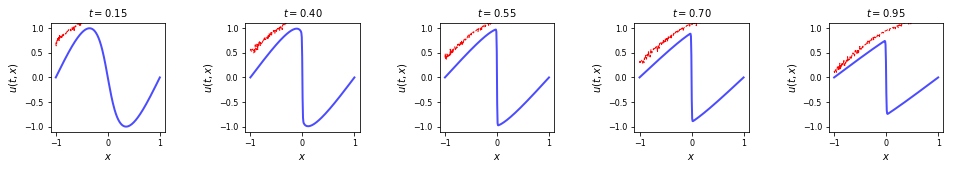

Iter: 4600,  discriminator: 1.6129,  generator: -0.5668,  entropy: -0.5677,  posterior: 0.0000,  pde: 0.0009
Iter: 4700,  discriminator: 1.3771,  generator: 0.0254,  entropy: 0.0238,  posterior: 0.0000,  pde: 0.0016
Iter: 4800,  discriminator: 1.3718,  generator: 0.0305,  entropy: 0.0292,  posterior: 0.0000,  pde: 0.0013
Iter: 4900,  discriminator: 1.3721,  generator: 0.0302,  entropy: 0.0255,  posterior: 0.0000,  pde: 0.0047
Iter: 5000,  discriminator: 1.3710,  generator: 0.0335,  entropy: 0.0262,  posterior: 0.0000,  pde: 0.0074


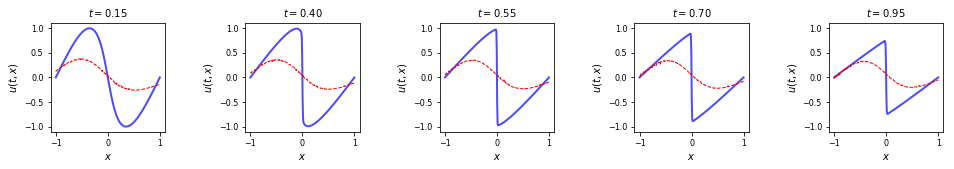

Iter: 5100,  discriminator: 1.3746,  generator: 0.0255,  entropy: 0.0161,  posterior: 0.0000,  pde: 0.0093
Iter: 5200,  discriminator: 1.3794,  generator: 0.0199,  entropy: 0.0077,  posterior: 0.0000,  pde: 0.0123
Iter: 5300,  discriminator: 1.3813,  generator: 0.0191,  entropy: 0.0083,  posterior: 0.0000,  pde: 0.0109
Iter: 5400,  discriminator: 1.3828,  generator: 0.0141,  entropy: 0.0052,  posterior: 0.0000,  pde: 0.0090
Iter: 5500,  discriminator: 1.3827,  generator: 0.0101,  entropy: 0.0024,  posterior: 0.0000,  pde: 0.0077


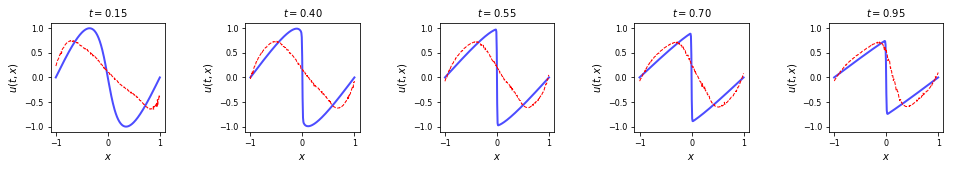

Iter: 5600,  discriminator: 1.3816,  generator: 0.0114,  entropy: 0.0049,  posterior: 0.0000,  pde: 0.0065
Iter: 5700,  discriminator: 1.3813,  generator: 0.0115,  entropy: 0.0063,  posterior: 0.0000,  pde: 0.0051
Iter: 5800,  discriminator: 1.3811,  generator: 0.0111,  entropy: 0.0064,  posterior: 0.0000,  pde: 0.0047
Iter: 5900,  discriminator: 1.3805,  generator: 0.0102,  entropy: 0.0062,  posterior: 0.0000,  pde: 0.0040
Iter: 6000,  discriminator: 1.3798,  generator: 0.0096,  entropy: 0.0061,  posterior: 0.0000,  pde: 0.0035


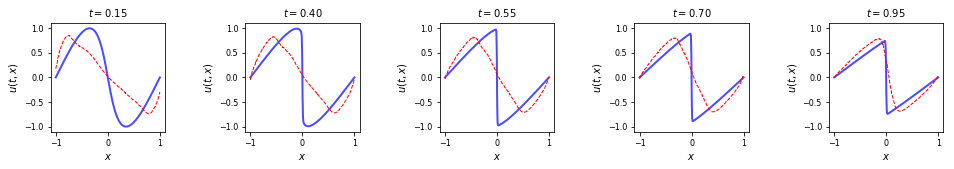

Iter: 6100,  discriminator: 1.3791,  generator: 0.0103,  entropy: 0.0067,  posterior: 0.0000,  pde: 0.0036
Iter: 6200,  discriminator: 1.3778,  generator: 0.0105,  entropy: 0.0069,  posterior: 0.0000,  pde: 0.0036
Iter: 6300,  discriminator: 1.3756,  generator: 0.0107,  entropy: 0.0062,  posterior: 0.0000,  pde: 0.0045
Iter: 6400,  discriminator: 1.3806,  generator: 0.0096,  entropy: 0.0027,  posterior: 0.0000,  pde: 0.0070
Iter: 6500,  discriminator: 1.3733,  generator: 0.0251,  entropy: 0.0190,  posterior: 0.0000,  pde: 0.0061


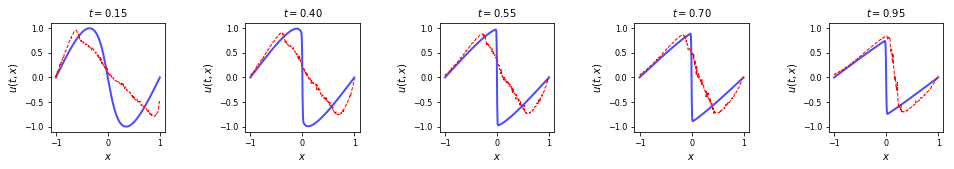

Iter: 6600,  discriminator: 1.3746,  generator: 0.0277,  entropy: 0.0241,  posterior: 0.0000,  pde: 0.0036
Iter: 6700,  discriminator: 1.3747,  generator: 0.0016,  entropy: -0.0058,  posterior: 0.0000,  pde: 0.0074
Iter: 6800,  discriminator: 1.3691,  generator: 0.0197,  entropy: 0.0115,  posterior: 0.0000,  pde: 0.0082
Iter: 6900,  discriminator: 1.3725,  generator: 0.0355,  entropy: 0.0268,  posterior: 0.0000,  pde: 0.0087
Iter: 7000,  discriminator: 1.3655,  generator: 0.0196,  entropy: 0.0104,  posterior: 0.0000,  pde: 0.0091


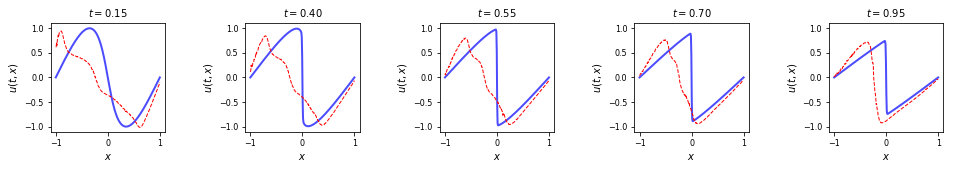

Iter: 7100,  discriminator: 1.3678,  generator: 0.0216,  entropy: 0.0126,  posterior: 0.0000,  pde: 0.0090
Iter: 7200,  discriminator: 1.3679,  generator: 0.0219,  entropy: 0.0079,  posterior: 0.0000,  pde: 0.0139
Iter: 7300,  discriminator: 1.3531,  generator: 0.0484,  entropy: 0.0374,  posterior: 0.0000,  pde: 0.0110
Iter: 7400,  discriminator: 1.3665,  generator: 0.0621,  entropy: 0.0502,  posterior: 0.0000,  pde: 0.0120
Iter: 7500,  discriminator: 1.3635,  generator: 0.0410,  entropy: 0.0176,  posterior: 0.0000,  pde: 0.0234


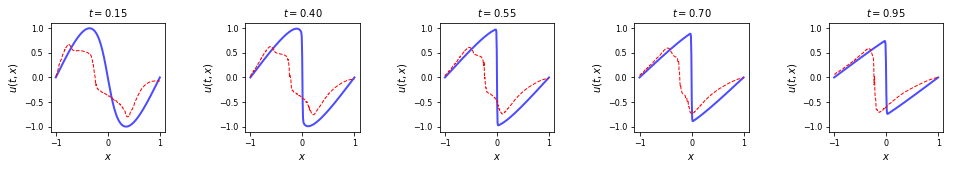

Iter: 7600,  discriminator: 1.3706,  generator: 0.0527,  entropy: 0.0291,  posterior: 0.0000,  pde: 0.0236
Iter: 7700,  discriminator: 1.3739,  generator: 0.0440,  entropy: 0.0230,  posterior: 0.0000,  pde: 0.0211
Iter: 7800,  discriminator: 1.3778,  generator: 0.0345,  entropy: 0.0186,  posterior: 0.0000,  pde: 0.0159
Iter: 7900,  discriminator: 1.3839,  generator: 0.0221,  entropy: 0.0080,  posterior: 0.0000,  pde: 0.0141
Iter: 8000,  discriminator: 1.3863,  generator: 0.0140,  entropy: 0.0045,  posterior: 0.0000,  pde: 0.0094


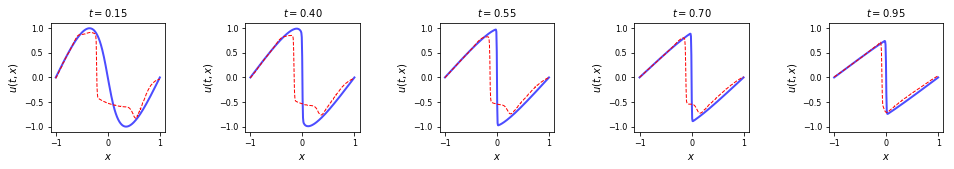

Iter: 8100,  discriminator: 1.3846,  generator: 0.0126,  entropy: 0.0057,  posterior: 0.0000,  pde: 0.0069
Iter: 8200,  discriminator: 1.3806,  generator: 0.0129,  entropy: 0.0073,  posterior: 0.0000,  pde: 0.0056
Iter: 8300,  discriminator: 1.3751,  generator: 0.0262,  entropy: 0.0226,  posterior: 0.0000,  pde: 0.0036
Iter: 8400,  discriminator: 1.3992,  generator: 0.0412,  entropy: 0.0287,  posterior: 0.0000,  pde: 0.0125
Iter: 8500,  discriminator: 1.3896,  generator: 0.0022,  entropy: -0.0009,  posterior: 0.0000,  pde: 0.0031


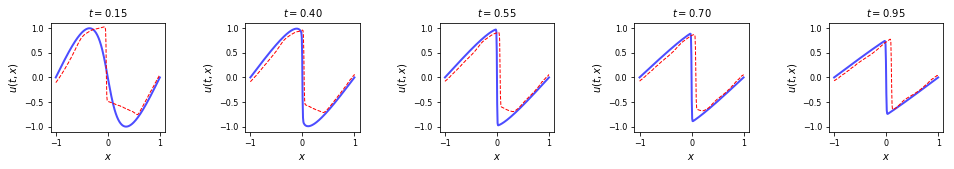

Iter: 8600,  discriminator: 1.3880,  generator: 0.0079,  entropy: 0.0043,  posterior: 0.0000,  pde: 0.0035
Iter: 8700,  discriminator: 1.3877,  generator: 0.0055,  entropy: 0.0024,  posterior: 0.0000,  pde: 0.0031
Iter: 8800,  discriminator: 1.3861,  generator: 0.0036,  entropy: 0.0013,  posterior: 0.0000,  pde: 0.0022
Iter: 8900,  discriminator: 1.3836,  generator: 0.0038,  entropy: 0.0019,  posterior: 0.0000,  pde: 0.0019
Iter: 9000,  discriminator: 1.3818,  generator: 0.0050,  entropy: 0.0032,  posterior: 0.0000,  pde: 0.0018


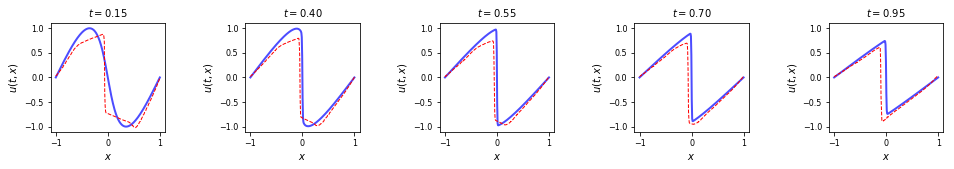

Iter: 9100,  discriminator: 1.3809,  generator: 0.0059,  entropy: 0.0048,  posterior: 0.0000,  pde: 0.0012
Iter: 9200,  discriminator: 1.3805,  generator: 0.0077,  entropy: 0.0063,  posterior: 0.0000,  pde: 0.0013
Iter: 9300,  discriminator: 1.3800,  generator: 0.0097,  entropy: 0.0083,  posterior: 0.0000,  pde: 0.0014
Iter: 9400,  discriminator: 1.3794,  generator: 0.0124,  entropy: 0.0098,  posterior: 0.0000,  pde: 0.0026
Iter: 9500,  discriminator: 1.3787,  generator: 0.0153,  entropy: 0.0119,  posterior: 0.0000,  pde: 0.0034


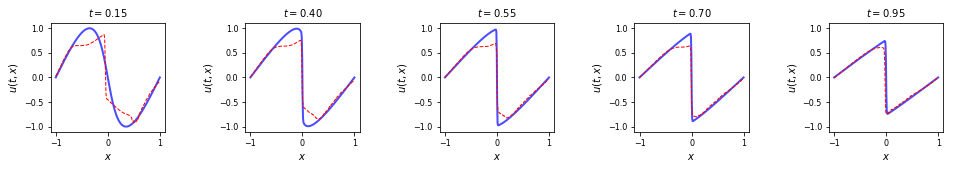

Iter: 9600,  discriminator: 1.3822,  generator: 0.0056,  entropy: 0.0001,  posterior: 0.0000,  pde: 0.0055
Iter: 9700,  discriminator: 1.3767,  generator: 0.0190,  entropy: 0.0152,  posterior: 0.0000,  pde: 0.0038
Iter: 9800,  discriminator: 1.3784,  generator: 0.0142,  entropy: 0.0101,  posterior: 0.0000,  pde: 0.0042
Iter: 9900,  discriminator: 1.3765,  generator: 0.0155,  entropy: 0.0108,  posterior: 0.0000,  pde: 0.0046
Iter: 10000,  discriminator: 1.3767,  generator: 0.0180,  entropy: 0.0124,  posterior: 0.0000,  pde: 0.0056


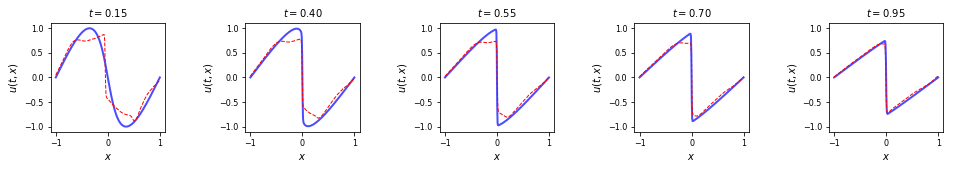

Iter: 10100,  discriminator: 1.3769,  generator: 0.0222,  entropy: 0.0149,  posterior: 0.0000,  pde: 0.0073
Iter: 10200,  discriminator: 1.3763,  generator: 0.0237,  entropy: 0.0153,  posterior: 0.0000,  pde: 0.0083
Iter: 10300,  discriminator: 1.3761,  generator: 0.0273,  entropy: 0.0151,  posterior: 0.0000,  pde: 0.0123
Iter: 10400,  discriminator: 1.3773,  generator: 0.0227,  entropy: 0.0120,  posterior: 0.0000,  pde: 0.0107
Iter: 10500,  discriminator: 1.3758,  generator: 0.0206,  entropy: 0.0129,  posterior: 0.0000,  pde: 0.0077


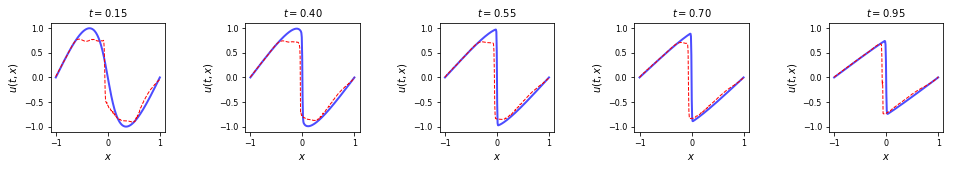

Iter: 10600,  discriminator: 1.4757,  generator: -0.0978,  entropy: -0.1356,  posterior: 0.0000,  pde: 0.0378
Iter: 10700,  discriminator: 1.3742,  generator: 0.0462,  entropy: 0.0349,  posterior: 0.0000,  pde: 0.0113
Iter: 10800,  discriminator: 1.3790,  generator: 0.0253,  entropy: 0.0143,  posterior: 0.0000,  pde: 0.0110
Iter: 10900,  discriminator: 1.3781,  generator: 0.0232,  entropy: 0.0129,  posterior: 0.0000,  pde: 0.0103
Iter: 11000,  discriminator: 1.3795,  generator: 0.0196,  entropy: 0.0104,  posterior: 0.0000,  pde: 0.0092


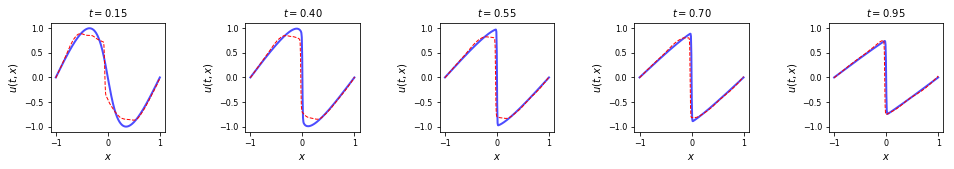

Iter: 11100,  discriminator: 1.3820,  generator: 0.0171,  entropy: 0.0071,  posterior: 0.0000,  pde: 0.0100
Iter: 11200,  discriminator: 1.3832,  generator: 0.0169,  entropy: 0.0064,  posterior: 0.0000,  pde: 0.0105
Iter: 11300,  discriminator: 1.3851,  generator: 0.0136,  entropy: 0.0034,  posterior: 0.0000,  pde: 0.0101
Iter: 11400,  discriminator: 1.3858,  generator: 0.0142,  entropy: 0.0019,  posterior: 0.0000,  pde: 0.0123
Iter: 11500,  discriminator: 1.3860,  generator: 0.0108,  entropy: 0.0015,  posterior: 0.0000,  pde: 0.0094


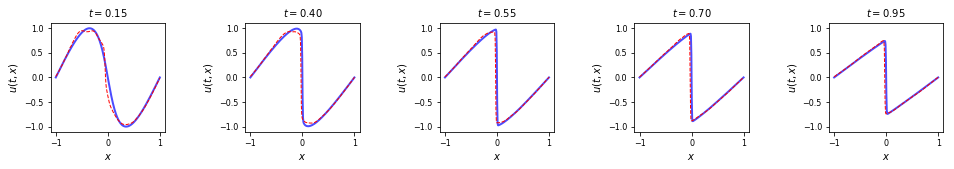

Iter: 11600,  discriminator: 1.3868,  generator: 0.0094,  entropy: 0.0002,  posterior: 0.0000,  pde: 0.0092
Iter: 11700,  discriminator: 1.3864,  generator: 0.0092,  entropy: 0.0004,  posterior: 0.0000,  pde: 0.0087
Iter: 11800,  discriminator: 1.3872,  generator: 0.0088,  entropy: -0.0004,  posterior: 0.0000,  pde: 0.0092
Iter: 11900,  discriminator: 1.3876,  generator: 0.0066,  entropy: -0.0010,  posterior: 0.0000,  pde: 0.0076
Iter: 12000,  discriminator: 1.3872,  generator: 0.0043,  entropy: -0.0008,  posterior: 0.0000,  pde: 0.0051


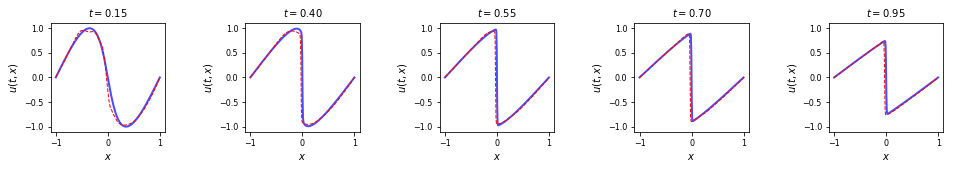

Iter: 12100,  discriminator: 1.3869,  generator: 0.0038,  entropy: -0.0008,  posterior: 0.0000,  pde: 0.0046
Iter: 12200,  discriminator: 1.3865,  generator: 0.0042,  entropy: -0.0008,  posterior: 0.0000,  pde: 0.0050
Iter: 12300,  discriminator: 1.3860,  generator: 0.0024,  entropy: -0.0001,  posterior: 0.0000,  pde: 0.0025
Iter: 12400,  discriminator: 1.3855,  generator: 0.0024,  entropy: 0.0004,  posterior: 0.0000,  pde: 0.0020
Iter: 12500,  discriminator: 1.3851,  generator: 0.0027,  entropy: 0.0007,  posterior: 0.0000,  pde: 0.0020


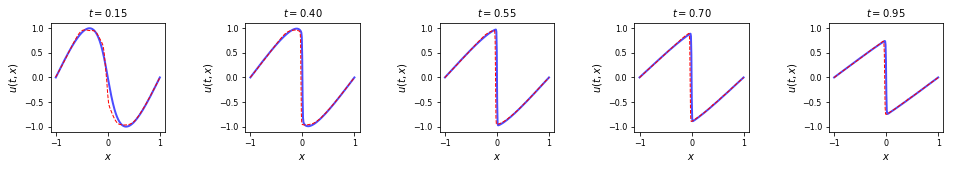

Iter: 12600,  discriminator: 1.3848,  generator: 0.0031,  entropy: 0.0014,  posterior: 0.0000,  pde: 0.0017
Iter: 12700,  discriminator: 1.3847,  generator: 0.0029,  entropy: 0.0015,  posterior: 0.0000,  pde: 0.0014
Iter: 12800,  discriminator: 1.3844,  generator: 0.0035,  entropy: 0.0020,  posterior: 0.0000,  pde: 0.0015
Iter: 12900,  discriminator: 1.3842,  generator: 0.0037,  entropy: 0.0024,  posterior: 0.0000,  pde: 0.0013
Iter: 13000,  discriminator: 1.3841,  generator: 0.0043,  entropy: 0.0027,  posterior: 0.0000,  pde: 0.0016


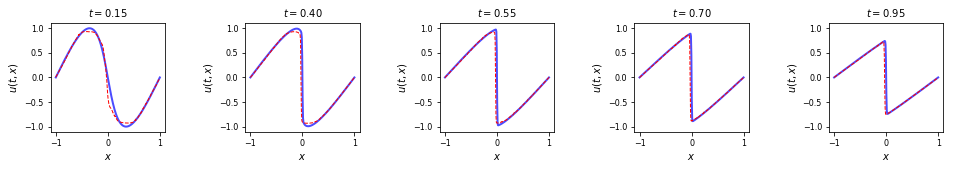

Iter: 13100,  discriminator: 1.3838,  generator: 0.0049,  entropy: 0.0032,  posterior: 0.0000,  pde: 0.0017
Iter: 13200,  discriminator: 1.3837,  generator: 0.0054,  entropy: 0.0037,  posterior: 0.0000,  pde: 0.0018
Iter: 13300,  discriminator: 1.3836,  generator: 0.0058,  entropy: 0.0033,  posterior: 0.0000,  pde: 0.0025
Iter: 13400,  discriminator: 1.3837,  generator: 0.0066,  entropy: 0.0039,  posterior: 0.0000,  pde: 0.0027
Iter: 13500,  discriminator: 1.3836,  generator: 0.0088,  entropy: 0.0062,  posterior: 0.0000,  pde: 0.0027


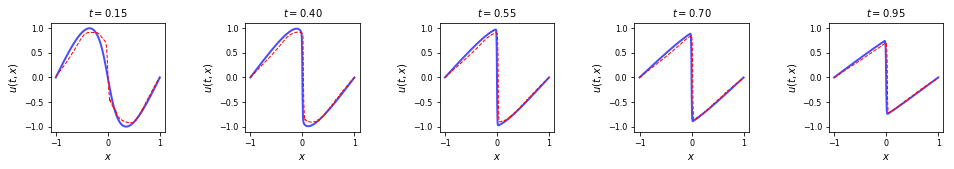

Iter: 13600,  discriminator: 1.3819,  generator: 0.0057,  entropy: 0.0040,  posterior: 0.0000,  pde: 0.0017
Iter: 13700,  discriminator: 1.3842,  generator: 0.0088,  entropy: 0.0061,  posterior: 0.0000,  pde: 0.0027
Iter: 13800,  discriminator: 1.3862,  generator: 0.0003,  entropy: -0.0012,  posterior: 0.0000,  pde: 0.0015
Iter: 13900,  discriminator: 1.3851,  generator: 0.0017,  entropy: 0.0002,  posterior: 0.0000,  pde: 0.0016
Iter: 14000,  discriminator: 1.3862,  generator: 0.0031,  entropy: 0.0014,  posterior: 0.0000,  pde: 0.0017


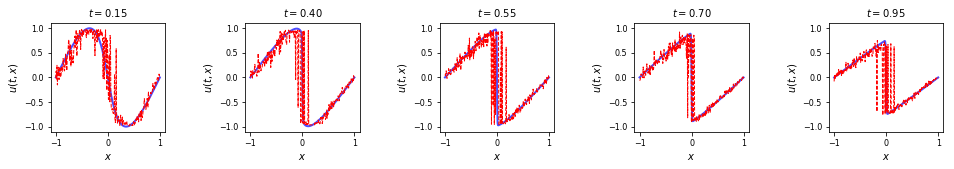

Iter: 14100,  discriminator: 1.3842,  generator: 0.0038,  entropy: 0.0024,  posterior: 0.0000,  pde: 0.0014
Iter: 14200,  discriminator: 1.3855,  generator: 0.0015,  entropy: -0.0000,  posterior: 0.0000,  pde: 0.0016
Iter: 14300,  discriminator: 1.3823,  generator: 0.0084,  entropy: 0.0071,  posterior: 0.0000,  pde: 0.0013
Iter: 14400,  discriminator: 1.3842,  generator: 0.0057,  entropy: 0.0041,  posterior: 0.0000,  pde: 0.0016
Iter: 14500,  discriminator: 1.3868,  generator: 0.0001,  entropy: -0.0016,  posterior: 0.0000,  pde: 0.0017


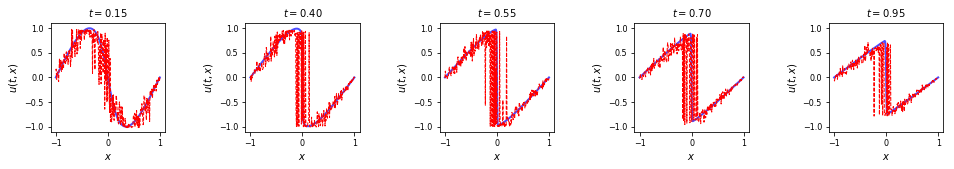

Iter: 14600,  discriminator: 1.3853,  generator: 0.0024,  entropy: 0.0006,  posterior: 0.0000,  pde: 0.0018
Iter: 14700,  discriminator: 1.3869,  generator: 0.0005,  entropy: -0.0012,  posterior: 0.0000,  pde: 0.0017
Iter: 14800,  discriminator: 1.3864,  generator: 0.0010,  entropy: -0.0011,  posterior: 0.0000,  pde: 0.0021
Iter: 14900,  discriminator: 1.3848,  generator: 0.0030,  entropy: 0.0014,  posterior: 0.0000,  pde: 0.0016
Iter: 15000,  discriminator: 1.3843,  generator: 0.0060,  entropy: 0.0045,  posterior: 0.0000,  pde: 0.0015


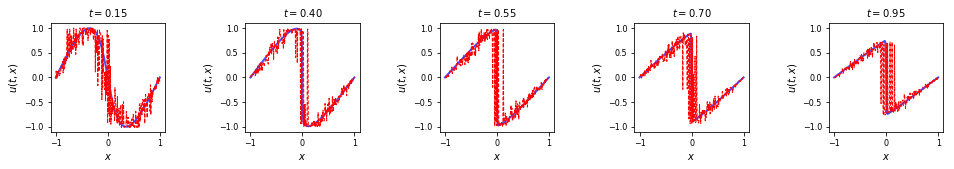

Iter: 15100,  discriminator: 1.3849,  generator: 0.0025,  entropy: 0.0010,  posterior: 0.0000,  pde: 0.0015
Iter: 15200,  discriminator: 1.3851,  generator: 0.0027,  entropy: 0.0015,  posterior: 0.0000,  pde: 0.0011
Iter: 15300,  discriminator: 1.3845,  generator: 0.0041,  entropy: 0.0026,  posterior: 0.0000,  pde: 0.0015
Iter: 15400,  discriminator: 1.3849,  generator: 0.0043,  entropy: 0.0031,  posterior: 0.0000,  pde: 0.0012
Iter: 15500,  discriminator: 1.3866,  generator: -0.0005,  entropy: -0.0025,  posterior: 0.0000,  pde: 0.0020


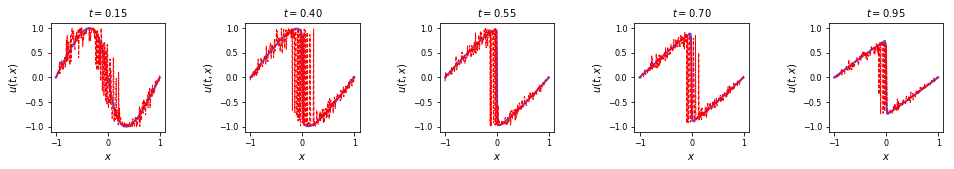

Iter: 15600,  discriminator: 1.3851,  generator: 0.0040,  entropy: 0.0024,  posterior: 0.0000,  pde: 0.0016
Iter: 15700,  discriminator: 1.3854,  generator: 0.0018,  entropy: 0.0003,  posterior: 0.0000,  pde: 0.0015
Iter: 15800,  discriminator: 1.3852,  generator: 0.0032,  entropy: 0.0010,  posterior: 0.0000,  pde: 0.0022
Iter: 15900,  discriminator: 1.3876,  generator: -0.0032,  entropy: -0.0047,  posterior: 0.0000,  pde: 0.0015
Iter: 16000,  discriminator: 1.3831,  generator: 0.0066,  entropy: 0.0047,  posterior: 0.0000,  pde: 0.0019


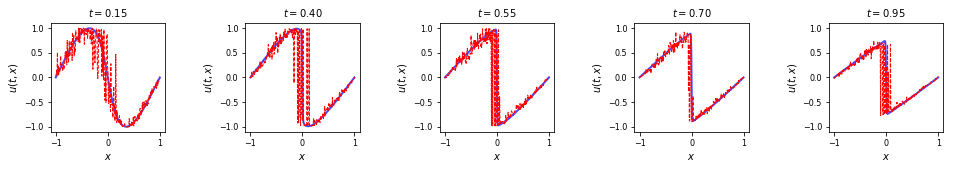

Iter: 16100,  discriminator: 1.3847,  generator: 0.0017,  entropy: 0.0002,  posterior: 0.0000,  pde: 0.0014
Iter: 16200,  discriminator: 1.3841,  generator: 0.0053,  entropy: 0.0034,  posterior: 0.0000,  pde: 0.0019
Iter: 16300,  discriminator: 1.3837,  generator: 0.0065,  entropy: 0.0045,  posterior: 0.0000,  pde: 0.0020
Iter: 16400,  discriminator: 1.3826,  generator: 0.0078,  entropy: 0.0056,  posterior: 0.0000,  pde: 0.0022
Iter: 16500,  discriminator: 1.3832,  generator: 0.0060,  entropy: 0.0043,  posterior: 0.0000,  pde: 0.0017


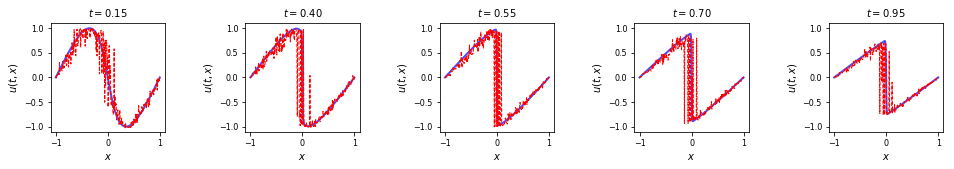

Iter: 16600,  discriminator: 1.3872,  generator: -0.0014,  entropy: -0.0033,  posterior: 0.0000,  pde: 0.0019
Iter: 16700,  discriminator: 1.3850,  generator: 0.0032,  entropy: -0.0002,  posterior: 0.0000,  pde: 0.0034
Iter: 16800,  discriminator: 1.3861,  generator: 0.0026,  entropy: 0.0005,  posterior: 0.0000,  pde: 0.0020
Iter: 16900,  discriminator: 1.3851,  generator: 0.0016,  entropy: -0.0000,  posterior: 0.0000,  pde: 0.0016
Iter: 17000,  discriminator: 1.3849,  generator: 0.0011,  entropy: -0.0004,  posterior: 0.0000,  pde: 0.0016


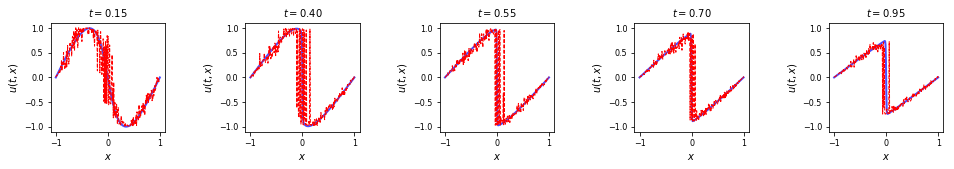

Iter: 17100,  discriminator: 1.3812,  generator: 0.0082,  entropy: 0.0063,  posterior: 0.0000,  pde: 0.0018
Iter: 17200,  discriminator: 1.3844,  generator: 0.0044,  entropy: 0.0026,  posterior: 0.0000,  pde: 0.0018
Iter: 17300,  discriminator: 1.3833,  generator: 0.0041,  entropy: 0.0021,  posterior: 0.0000,  pde: 0.0020
Iter: 17400,  discriminator: 1.3846,  generator: 0.0026,  entropy: 0.0005,  posterior: 0.0000,  pde: 0.0022
Iter: 17500,  discriminator: 1.3814,  generator: 0.0083,  entropy: 0.0065,  posterior: 0.0000,  pde: 0.0018


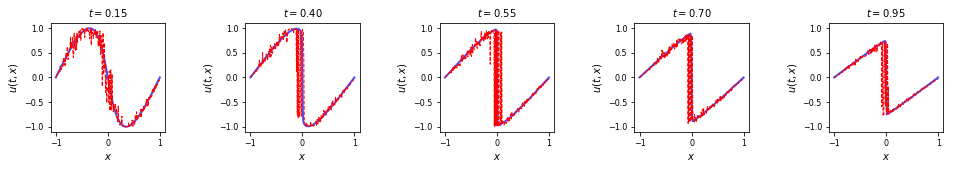

Iter: 17600,  discriminator: 1.3824,  generator: 0.0070,  entropy: 0.0048,  posterior: 0.0000,  pde: 0.0022
Iter: 17700,  discriminator: 1.3837,  generator: 0.0027,  entropy: 0.0000,  posterior: 0.0000,  pde: 0.0027
Iter: 17800,  discriminator: 1.3808,  generator: 0.0103,  entropy: 0.0081,  posterior: 0.0000,  pde: 0.0022
Iter: 17900,  discriminator: 1.3793,  generator: 0.0109,  entropy: 0.0086,  posterior: 0.0000,  pde: 0.0024
Iter: 18000,  discriminator: 1.3807,  generator: 0.0099,  entropy: 0.0063,  posterior: 0.0000,  pde: 0.0036


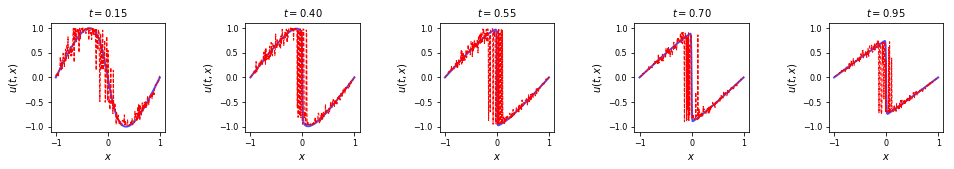

Iter: 18100,  discriminator: 1.3812,  generator: 0.0097,  entropy: 0.0075,  posterior: 0.0000,  pde: 0.0023
Iter: 18200,  discriminator: 1.3808,  generator: 0.0101,  entropy: 0.0067,  posterior: 0.0000,  pde: 0.0034
Iter: 18300,  discriminator: 1.3798,  generator: 0.0109,  entropy: 0.0074,  posterior: 0.0000,  pde: 0.0035
Iter: 18400,  discriminator: 1.3794,  generator: 0.0120,  entropy: 0.0092,  posterior: 0.0000,  pde: 0.0028
Iter: 18500,  discriminator: 1.3840,  generator: 0.0046,  entropy: 0.0008,  posterior: 0.0000,  pde: 0.0037


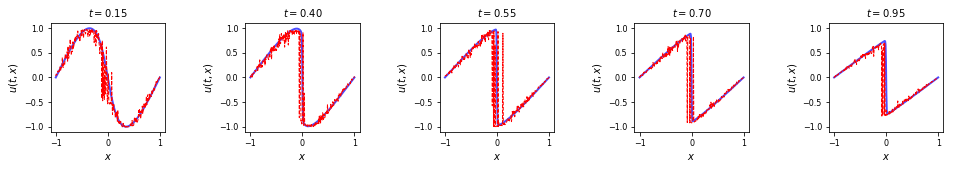

Iter: 18600,  discriminator: 1.3863,  generator: -0.0006,  entropy: -0.0046,  posterior: 0.0000,  pde: 0.0039
Iter: 18700,  discriminator: 1.3787,  generator: 0.0105,  entropy: 0.0078,  posterior: 0.0000,  pde: 0.0027
Iter: 18800,  discriminator: 1.3843,  generator: 0.0002,  entropy: -0.0016,  posterior: 0.0000,  pde: 0.0018
Iter: 18900,  discriminator: 1.3810,  generator: 0.0091,  entropy: 0.0056,  posterior: 0.0000,  pde: 0.0035
Iter: 19000,  discriminator: 1.3825,  generator: 0.0059,  entropy: 0.0021,  posterior: 0.0000,  pde: 0.0038


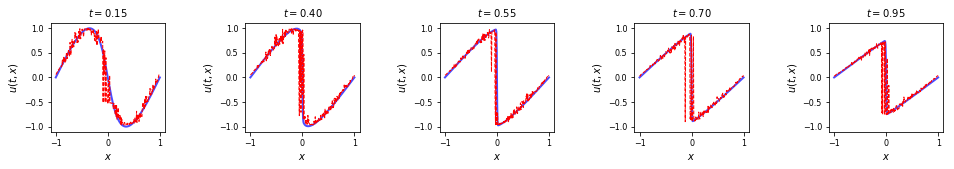

Iter: 19100,  discriminator: 1.3825,  generator: 0.0062,  entropy: 0.0023,  posterior: 0.0000,  pde: 0.0039
Iter: 19200,  discriminator: 1.3774,  generator: 0.0167,  entropy: 0.0123,  posterior: 0.0000,  pde: 0.0044
Iter: 19300,  discriminator: 1.3818,  generator: 0.0056,  entropy: 0.0035,  posterior: 0.0000,  pde: 0.0020
Iter: 19400,  discriminator: 1.3796,  generator: 0.0072,  entropy: 0.0041,  posterior: 0.0000,  pde: 0.0031
Iter: 19500,  discriminator: 1.3791,  generator: 0.0153,  entropy: 0.0110,  posterior: 0.0000,  pde: 0.0043


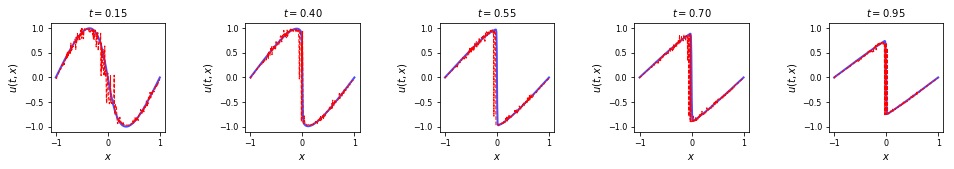

Iter: 19600,  discriminator: 1.3767,  generator: 0.0178,  entropy: 0.0135,  posterior: 0.0000,  pde: 0.0044
Iter: 19700,  discriminator: 1.3744,  generator: 0.0202,  entropy: 0.0165,  posterior: 0.0000,  pde: 0.0036
Iter: 19800,  discriminator: 1.3800,  generator: 0.0084,  entropy: 0.0050,  posterior: 0.0000,  pde: 0.0034
Iter: 19900,  discriminator: 1.3821,  generator: 0.0043,  entropy: 0.0022,  posterior: 0.0000,  pde: 0.0021


In [20]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 1], name='x')
t = tf.placeholder(tf.float32, [None, 1], name='t')

with tf.variable_scope('generator'):
    x_collocation = tf.placeholder(tf.float32, [None, 1], name='x_collocation')
    t_collocation = tf.placeholder(tf.float32, [None, 1], name='t_collocation')
    u_sample_collocation = tf.placeholder(tf.float32, [None, latent_var_nb], name='u_sample_collocation')
    u_sample = tf.placeholder(tf.float32, [None, latent_var_nb], name='u_sample')    
    mlp_config_generator = MLPConfig(layer_size_lst=gen_layer_lst,
                                     activation_lst=gen_activation_lst,
                                     main_name='generator')

    net_pde = create_mlp(tf.concat([x, t, u_sample], 1), mlp_config_generator)
    gen_pde = tf.concat([x, t, net_pde], axis=1, name='gen_pde')
    mlp_config_posterior = MLPConfig(layer_size_lst=pos_layer_lst, 
                                   activation_lst=pos_activation_lst, 
                                   main_name='posterior')
    logits_posterior = create_mlp(gen_pde, mlp_config_posterior)
    net_pde_collocation = create_mlp(tf.concat([x_collocation, t_collocation, u_sample_collocation], 1), mlp_config_generator, reuse=True)
    net_pde_residuals = net_pde_res_burger(net_pde_collocation, x_collocation, t_collocation)
    
    
with tf.variable_scope('discriminator') as scope:
    u_real = tf.placeholder(tf.float32, [None, 1])
    mlp_config_discriminator = MLPConfig(layer_size_lst=dis_layer_lst, 
                                         activation_lst=dis_activation_lst, 
                                         main_name='discriminator')
    logits_real = create_mlp(tf.concat([x, t, u_real], 1), mlp_config_discriminator)
    scope.reuse_variables()
    logits_fake = create_mlp(gen_pde, mlp_config_discriminator)

dis_loss = discriminator_loss(logits_real, logits_fake)
gen_loss, gen_loss_entropy, gen_loss_posterior, gen_loss_pde = generator_loss(logits_fake, logits_posterior, net_pde_residuals, w_posterior_loss, w_pde_loss)

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator")
dis_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="discriminator")
gen_minimize_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(gen_loss, var_list=gen_vars) # D Train step
dis_minimize_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(dis_loss, var_list=dis_vars) # D Train step

init = tf.global_variables_initializer()
model_saver = tf.train.Saver()

with tf.Session() as sess:        
    # Run the initializer
    sess.run(init)
    for i in range(iter_nb):
        idx_batch = np.random.choice(u_train.shape[0], batch_size, replace=False)   
        u_real_batch = u_train[idx_batch, :]
        u_sample_batch = np.random.normal(size=(u_real_batch.shape[0], latent_var_nb))
        x_batch = x_train[idx_batch, :]
        t_batch = t_train[idx_batch, :]
        idx_batch_collocation = np.random.choice(u_test.shape[0], batch_size_collocation, replace=False)   
        x_collocation_batch = x_test[idx_batch_collocation, :]
        t_collocation_batch = t_test[idx_batch_collocation, :]
#         gd = griddata((x_batch.flatten(), t_batch.flatten()), u_sample_batch.flatten(), (x_collocation_batch.flatten(), t_collocation_batch.flatten()), method='linear')
        u_sample_batch_collocation = np.random.normal(size=(x_collocation_batch.shape[0], latent_var_nb))
        for _ in range(dis_steps_nb):
            run_lst = [dis_minimize_step, dis_loss]
            feed_dict = {u_real: u_real_batch, u_sample: u_sample_batch, x: x_batch, t: t_batch, x_collocation: x_collocation_batch, t_collocation: t_collocation_batch, u_sample_collocation: u_sample_batch_collocation}
            _, d_loss = sess.run(run_lst, feed_dict=feed_dict)

        for _ in range(gen_steps_nb):
            run_lst = [gen_minimize_step, gen_loss, gen_loss_entropy, gen_loss_posterior, gen_loss_pde]
            feed_dict = feed_dict={u_sample: u_sample_batch,  x: x_batch, t: t_batch, x_collocation: x_collocation_batch, t_collocation: t_collocation_batch, u_sample_collocation: u_sample_batch_collocation}
            _, g_loss, g_loss_entropy, g_loss_posterior, g_loss_pde = sess.run(run_lst, feed_dict=feed_dict)
            
        if i==0:
            loss_array = np.array([i,d_loss,g_loss,g_loss_entropy, g_loss_posterior, g_loss_pde])
        if i % 100 == 0:
            print("Iter: %d,  discriminator: %.4f,  generator: %.4f,  entropy: %.4f,  posterior: %.4f,  pde: %.4f" % (i, d_loss, g_loss, g_loss_entropy, g_loss_posterior, g_loss_pde))
            loss_array = np.vstack((loss_array, np.array([i,d_loss,g_loss,g_loss_entropy, g_loss_posterior, g_loss_pde])))

        if i % 500 == 0:
            u_test_sample = np.random.normal(size=(u_test.shape[0], latent_var_nb))
            x_gen = sess.run(gen_pde, feed_dict={u_sample: u_test_sample, x: x_test, t: t_test, u_sample_collocation: u_sample_batch_collocation})
            u_pred = griddata(df_data.loc[idx_test,['x', 't']], x_gen[:,2].flatten(), (x_mesh, t_mesh), method='cubic')

            cut_lst = [15, 40, 55, 70, 95]
            fig = plt.figure(figsize=(16,2))
            ax = fig.add_subplot(111)
            ax.axis('off')
            plot_nb = len(cut_lst)
            gs0 = gridspec.GridSpec(1, plot_nb, wspace=0.7)
            for i in range(plot_nb):
                plot_cut_test(grid_spec=gs0[0,i], x=x_data, actual=u_actual, pred=u_pred, cut=cut_lst[i], x_lim=[-1.1,1.1], y_lim=[-1.1,1.1])

            plt.show()
    model_saver.save(sess, os.path.join(path_models, "gan_burger.ckpt"))

In [21]:
idx_batch = np.random.choice(u_train.shape[0], batch_size, replace=False)   
u_real_batch = u_train[idx_batch, :]
u_sample_batch = np.random.normal(size=(u_real_batch.shape[0], latent_var_nb))
x_batch = x_train[idx_batch, :]
t_batch = t_train[idx_batch, :]
idx_batch_collocation = np.random.choice(u_test.shape[0], batch_size_collocation, replace=False)   
x_collocation_batch = x_test[idx_batch_collocation, :]
t_collocation_batch = t_test[idx_batch_collocation, :]
u_sample_batch_collocation = np.random.normal(size=(x_collocation_batch.shape[0], latent_var_nb))


In [22]:
print('x_batch.shape', x_batch.shape)
print('t_batch.shape', t_batch.shape)
print('u_sample_batch.shape', u_sample_batch.shape)
print('x_collocation_batch.shape', x_collocation_batch.shape)
print('t_collocation_batch.shape', t_collocation_batch.shape)


x_batch.shape (150, 1)
t_batch.shape (150, 1)
u_sample_batch.shape (150, 1)
x_collocation_batch.shape (2000, 1)
t_collocation_batch.shape (2000, 1)


INFO:tensorflow:Restoring parameters from D:\Tenokonda Ltd Dropbox\Cedric Fraces\Aiolitic\Projects\PhysicsInformed\lib\resources\models\gan_burger.ckpt


C:\Users\cedric\Anaconda3\envs\py36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


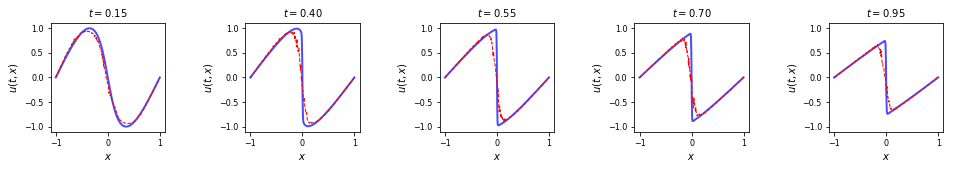

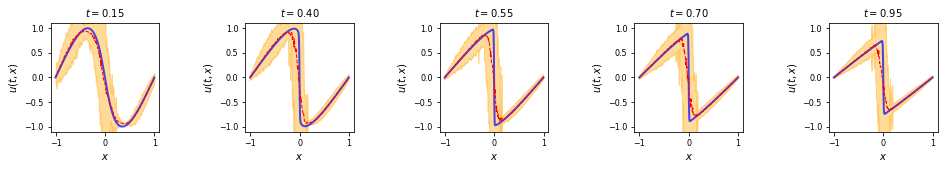

In [26]:
x_gen_mean = None
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(os.path.join(path_models,'gan_burger.ckpt.meta'))
    saver.restore(sess, tf.train.latest_checkpoint(path_models))
    graph = tf.get_default_graph()
    
    u_sample = graph.get_tensor_by_name("generator/u_sample:0")
    x = graph.get_tensor_by_name("x:0")
    t = graph.get_tensor_by_name("t:0")
    
    gen_pde = graph.get_tensor_by_name("generator/gen_pde:0")

    u_sample_test = np.random.normal(size=(u_test.shape[0], latent_var_nb))
    x_gen = sess.run(gen_pde, feed_dict={u_sample: u_sample_test, x: x_test, t: t_test})
    x_gen_array = np.array(x_gen[:,2])
    for i in range(100):
        u_sample_test = np.random.normal(size=(u_test.shape[0], latent_var_nb))
        x_gen = sess.run(gen_pde, feed_dict={u_sample: u_sample_test, x: x_test, t: t_test})
        x_gen_array = np.vstack((x_gen_array, x_gen[:,2]))
    x_gen_mean = np.mean(x_gen_array, axis=0)
    x_gen_std = np.std(x_gen_array, axis=0)
    x_gen[:,2] = x_gen_mean
    
    u_pred = griddata(df_data.loc[idx_test,['x', 't']], x_gen[:,2].flatten(), (x_mesh, t_mesh), method='cubic')
    u_pred_min = griddata(df_data.loc[idx_test,['x', 't']], x_gen_mean - 3.0*x_gen_std, (x_mesh, t_mesh), method='cubic')
    u_pred_max = griddata(df_data.loc[idx_test,['x', 't']], x_gen_mean + 3.0*x_gen_std, (x_mesh, t_mesh), method='cubic')
    cut_lst = [15, 40, 55, 70, 95]
    fig = plt.figure(figsize=(16,2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    plot_nb = len(cut_lst)
    gs0 = gridspec.GridSpec(1, plot_nb, wspace=0.7)
    for i in range(plot_nb):
        plot_cut_test(grid_spec=gs0[0,i], x=x_data, actual=u_actual, pred=u_pred, cut=cut_lst[i], x_lim=[-1.1,1.1], y_lim=[-1.1,1.1])
    plt.show()
    fig = plt.figure(figsize=(16,2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    plot_nb = len(cut_lst)
    gs0 = gridspec.GridSpec(1, plot_nb, wspace=0.7)
    for i in range(plot_nb):
        plot_cut_test_std(grid_spec=gs0[0,i], x=x_data, actual=u_actual, pred=u_pred, pred_min=u_pred_min, pred_max=u_pred_max, cut=cut_lst[i], x_lim=[-1.1,1.1], y_lim=[-1.1,1.1])
    plt.show()

In [ ]:
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go

# Make plotly work with Jupyter notebook
init_notebook_mode()

pred = go.Scatter3d(
    x = df_data.t,
    y = df_data.x,
    z = u_pred.flatten(),
    marker = go.Marker(color='red', size=1.5),
    mode = 'markers'
)

actual = go.Scatter3d(
    x = df_data.t,
    y = df_data.x,
    z = df_data.u,
    marker = go.Marker(color='blue', size=1.5),
    mode = 'markers'
)

data = go.Data([pred, actual])

iplot(data)

In [ ]:
df_loss = pd.DataFrame(loss_array, columns=['iteration', 'discriminator', 'generator', 'entropy', 'posterior', 'pde'])
# df.plot(x=df.iteration, y=df.columns[1:], figsize=(17,8), fontsize=12)
df_loss.iteration = df_loss.iteration.astype(int)
df_loss.set_index(df_loss.iteration, inplace=True)
df_loss.drop(['iteration'], axis=1, inplace=True)
df_loss.plot(figsize=(17,8), fontsize=12)